In [2]:
%load_ext Cython

Iso contour implementation using Cython with a insertion algorithm to merge polygons together. The image is split into several blocks to find local iso contours. The result is finally merge all together. This way allow a full OpenMP optimization.

MarchingSquareCythonInsertOpenMp
================================

In [3]:
%%cython --cplus --compile-args=-std=c++11 --compile-args=-fopenmp --link-args=-fopenmp --force -a

import numpy
cimport numpy as cnumpy

from libcpp.vector cimport vector
from libcpp.list cimport list as clist
from libcpp cimport bool
from libc.math cimport fabs

from cython.parallel import prange
from cython.operator cimport dereference
from cython.operator cimport preincrement
cimport cython

# from libcpp.unordered_map cimport unordered_map
from libcpp.utility cimport pair
cdef extern from "<unordered_map>" namespace "std" nogil:
    cdef cppclass unordered_map[T, U]:
        ctypedef T key_type
        ctypedef U mapped_type
        ctypedef pair[const T, U] value_type
        cppclass iterator:
            pair[T, U]& operator*()
            iterator operator++()
            iterator operator--()
            bint operator==(iterator)
            bint operator!=(iterator)
        cppclass reverse_iterator:
            pair[T, U]& operator*()
            iterator operator++()
            iterator operator--()
            bint operator==(reverse_iterator)
            bint operator!=(reverse_iterator)
        cppclass const_iterator(iterator):
            pass
        cppclass const_reverse_iterator(reverse_iterator):
            pass
        unordered_map() except +
        unordered_map(unordered_map&) except +
        #unordered_map(key_compare&)
        U& operator[](T&)
        #unordered_map& operator=(unordered_map&)
        bint operator==(unordered_map&, unordered_map&)
        bint operator!=(unordered_map&, unordered_map&)
        bint operator<(unordered_map&, unordered_map&)
        bint operator>(unordered_map&, unordered_map&)
        bint operator<=(unordered_map&, unordered_map&)
        bint operator>=(unordered_map&, unordered_map&)
        U& at(T&)
        iterator begin()
        const_iterator const_begin "begin"()
        void clear()
        size_t count(T&)
        bint empty()
        iterator end()
        const_iterator const_end "end"()
        pair[iterator, iterator] equal_range(T&)
        #pair[const_iterator, const_iterator] equal_range(key_type&)
        iterator erase(iterator)
        iterator erase(iterator, iterator)
        size_t erase(T&)
        iterator find(T&)
        const_iterator const_find "find"(T&)
        pair[iterator, bint] insert(pair[T, U]) # XXX pair[T,U]&
        iterator insert(iterator, pair[T, U]) # XXX pair[T,U]&
        #void insert(input_iterator, input_iterator)
        #key_compare key_comp()
        iterator lower_bound(T&)
        const_iterator const_lower_bound "lower_bound"(T&)
        size_t max_size()
        reverse_iterator rbegin()
        const_reverse_iterator const_rbegin "rbegin"()
        reverse_iterator rend()
        const_reverse_iterator const_rend "rend"()
        size_t size()
        void swap(unordered_map&)
        iterator upper_bound(T&)
        const_iterator const_upper_bound "upper_bound"(T&)
        #value_compare value_comp()
        void max_load_factor(float)
        float max_load_factor()
        void reserve(size_t)
        size_t bucket_count()


cdef double EPSILON = numpy.finfo(numpy.float64).eps

cdef cnumpy.int8_t[2] *EDGE_TO_POINT = [[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]]
cdef cnumpy.int8_t[5] *CELL_TO_EDGE = [
                                       # array of index containing
                                       # id0: number of segments (up to 2)
                                       # id1: index of the start of the 1st edge
                                       # id2: index of the end of the 1st edge
                                       # id3: index of the start of the 2nd edge
                                       # id4: index of the end of the 2nd edge
                                       [0, 0, 0, 0, 0],  # Case 0: 0000: nothing
                                       [1, 0, 3, 0, 0],  # Case 1: 0001
                                       [1, 0, 1, 0, 0],  # Case 2: 0010
                                       [1, 1, 3, 0, 0],  # Case 3: 0011

                                       [1, 1, 2, 0, 0],  # Case 4: 0100
                                       [2, 0, 1, 2, 3],  # Case 5: 0101 > ambiguous
                                       [1, 0, 2, 0, 0],  # Case 6: 0110
                                       [1, 2, 3, 0, 0],  # Case 7: 0111

                                       [1, 2, 3, 0, 0],  # Case 8: 1000
                                       [1, 0, 2, 0, 0],  # Case 9: 1001
                                       [2, 0, 3, 1, 2],  # Case 10: 1010 > ambiguous
                                       [1, 1, 2, 0, 0],  # Case 11: 1011

                                       [1, 1, 3, 0, 0],  # Case 12: 1100
                                       [1, 0, 1, 0, 0],  # Case 13: 1101
                                       [1, 0, 3, 0, 0],  # Case 14: 1110
                                       [0, 0, 0, 0, 0],  # Case 15: 1111
                                      ]

ctypedef cnumpy.int64_t hash_index_t

cdef struct point_t:
    cnumpy.float32_t x
    cnumpy.float32_t y

cdef cppclass polygon_description_t:
    hash_index_t begin
    hash_index_t end
    clist[point_t] points

    polygon_description_t() nogil:
        pass

cdef cppclass TileContext_t:
    int pos_x
    int pos_y
    int dim_x
    int dim_y

    clist[polygon_description_t*] final_polygons

    unordered_map[hash_index_t, polygon_description_t*] polygons

    TileContext_t() nogil:
        pass


cdef class MarchingSquareCythonInsertOpenMp(object):
    """Marching square using an insertion algorithm to reconstruct polygons
    on the fly while iterating input data.
    """

    cdef cnumpy.float32_t[:, :] _image
    cdef cnumpy.int8_t[:, :] _mask

    cdef cnumpy.float32_t *_image_ptr
    cdef cnumpy.int8_t *_mask_ptr
    cdef int _dim_x
    cdef int _dim_y
    cdef int _group_size
    cdef int _group_mode
    cdef bool _use_reverse
    """Check influence of the reverse function.
    If false, the result is not valid."""

    cdef TileContext_t* _final_context

    def __init__(self, image, mask=None, openmp_group_mode="tile", openmp_group_size=256, use_reverse=True):
        self._image = numpy.ascontiguousarray(image, numpy.float32)
        self._image_ptr = &self._image[0][0]
        if mask is not None:
            assert(image.shape == mask.shape)
            self._mask = numpy.ascontiguousarray(mask, numpy.int8)
            self._mask_ptr = &self._mask[0][0]
        else:
            self._mask = None
            self._mask_ptr = NULL
        self._group_mode = {"tile": 0, "row": 1, "col": 2}[openmp_group_mode]
        self._group_size = openmp_group_size
        self._use_reverse = use_reverse
        with nogil:
            self._dim_y = self._image.shape[0]
            self._dim_x = self._image.shape[1]

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _marching_squares(self, cnumpy.float64_t isovalue):
        cdef:
            int x, y, i
            vector[TileContext_t*] contexts
            TileContext_t *context
            int dim_x, dim_y

        if self._group_mode == 0:
            for y in range(0, self._dim_y - 1, self._group_size):
                for x in range(0, self._dim_x - 1, self._group_size):
                    context = self._create_context(x, y, self._group_size, self._group_size)
                    contexts.push_back(context)
        elif self._group_mode == 1:
            # row
            for y in range(0, self._dim_y - 1, self._group_size):
                context = self._create_context(0, y, self._dim_x - 1, self._group_size)
                contexts.push_back(context)
        elif self._group_mode == 2:
            # col
            for x in range(0, self._dim_x - 1, self._group_size):
                context = self._create_context(x, 0, self._group_size, self._dim_y - 1)
                contexts.push_back(context)
        else:
            # FIXME: Good to add check
            pass

        # openmp
        for i in prange(contexts.size(), nogil=True):
            self._marching_squares_mp(contexts[i], isovalue)

        if contexts.size() == 1:
            # shortcut
            self._final_context = contexts[0]
            return

        # merge
        self._final_context = new TileContext_t()
        self._final_context.polygons.reserve(self._dim_x * 2 + self._dim_y * 2)
        for i in range(contexts.size()):
            self._merge_context(self._final_context, contexts[i])
            del contexts[i]

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef TileContext_t *_create_context(self, int x, int y, int dim_x, int dim_y) nogil:
        cdef:
            TileContext_t *context
        context = new TileContext_t()
        context.pos_x = x
        context.pos_y = y
        context.dim_x = dim_x
        context.dim_y = dim_y
        if x + context.dim_x > self._dim_x - 1:
            context.dim_x = self._dim_x - 1 - x
        if y + context.dim_y > self._dim_y - 1:
            context.dim_y = self._dim_y - 1 - y
        if context.dim_x <= 0 or context.dim_y <= 0:
            del context
            return NULL
        return context

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _marching_squares_mp(self, TileContext_t *context, cnumpy.float64_t isovalue) nogil:
        cdef:
            int x, y, index
            cnumpy.float64_t tmpf
            cnumpy.float32_t *_image_ptr
            cnumpy.int8_t *_mask_ptr
            vector[TileContext_t*] contexts
            int dim_x, dim_y
            int bucket_count

        context.polygons.reserve(context.dim_x * 2 + context.dim_y * 2)
        bucket_count = context.polygons.bucket_count()
        _image_ptr = self._image_ptr + (context.pos_y * self._dim_x + context.pos_x)
        if self._mask_ptr != NULL:
            _mask_ptr = self._mask_ptr + (context.pos_y * self._dim_x + context.pos_x)
        else:
            _mask_ptr = NULL

        for y in range(context.pos_y, context.pos_y + context.dim_y):
            for x in range(context.pos_x, context.pos_x + context.dim_x):
                # Calculate index.
                index = 0
                if _image_ptr[0] > isovalue:
                    index += 1
                if _image_ptr[1] > isovalue:
                    index += 2
                if _image_ptr[self._dim_x] > isovalue:
                    index += 8
                if _image_ptr[self._dim_x + 1] > isovalue:
                    index += 4

                # Resolve ambiguity
                if index == 5 or index == 10:
                    # Calculate value of cell center (i.e. average of corners)
                    tmpf = 0.25 * (_image_ptr[0] +
                                   _image_ptr[1] +
                                   _image_ptr[self._dim_x] +
                                   _image_ptr[self._dim_x + 1])
                    # If below isovalue, swap
                    if tmpf <= isovalue:
                        if index == 5:
                            index = 10
                        else:
                            index = 5

                # Cache mask information
                if _mask_ptr != NULL:
                    _mask_ptr += 1
                    if _mask_ptr[0] > 0:
                        index += 16
                    if _mask_ptr[1] > 0:
                        index += 32
                    if _mask_ptr[self._dim_x] > 0:
                        index += 128
                    if _mask_ptr[self._dim_x + 1] > 0:
                        index += 64

                if index < 16 and index != 0 and index != 15:
                    self._insert_pattern(context, x, y, index, isovalue)

                _image_ptr += 1

            # There is a missing pixel at the end of each rows
            _image_ptr += self._dim_x - context.dim_x
            if _mask_ptr != NULL:
                _mask_ptr += self._dim_x - context.dim_x
        
        if bucket_count != context.polygons.bucket_count():
            with gil:
                # FIXME: Check if it can happen
                print("Bucket count changed from %d to %d" % (bucket_count, context.polygons.bucket_count()))

    cdef void _insert_pattern(self, TileContext_t *context, int x, int y, int pattern, cnumpy.float64_t isovalue) nogil:
        cdef:
            int segment
        for segment in range(CELL_TO_EDGE[pattern][0]):
            begin_edge = CELL_TO_EDGE[pattern][1 + segment * 2 + 0]
            end_edge = CELL_TO_EDGE[pattern][1 + segment * 2 + 1]
            self._insert_segment(context, x, y, begin_edge, end_edge, isovalue)

    cdef hash_index_t _create_hash_index(self, int x, int y, cnumpy.uint8_t edge) nogil:
        """Create an identifier for a tuple x-y-edge (which is reversible)

        There is no way to create hashable struct in cython. Then it uses
        a standard hashable type.

        For example, the tuple (x=0, y=0, edge=2) is equal to (x=1, y=0, edge=0)
        """
        cdef:
            hash_index_t v = 0
        if edge == 2:
            y += 1
            edge = 0
        elif edge == 3:
            x -= 1
            edge = 1
        # Avoid negative values
        x += 1
        y += 1

        v += edge
        v <<= 20
        v += x
        v <<= 20
        v += y
        return v

    cdef void _insert_segment(self, TileContext_t *context,
                              int x, int y,
                              cnumpy.uint8_t begin_edge,
                              cnumpy.uint8_t end_edge,
                              cnumpy.float64_t isovalue) nogil:
        cdef:
            int i
            point_t point
            hash_index_t begin, end
            polygon_description_t *description
            polygon_description_t *description_begin
            polygon_description_t *description_end
            unordered_map[hash_index_t, polygon_description_t*].iterator it_begin
            unordered_map[hash_index_t, polygon_description_t*].iterator it_end

        begin = self._create_hash_index(x, y, begin_edge)
        end = self._create_hash_index(x, y, end_edge)

        it_begin = context.polygons.find(begin)
        it_end = context.polygons.find(end)
        if it_begin == context.polygons.end() and it_end == context.polygons.end():
            # insert a new polygon
            description = new polygon_description_t()
            description.begin = begin
            description.end = end
            self._compute_point(x, y, begin_edge, isovalue, &point)
            description.points.push_back(point)
            self._compute_point(x, y, end_edge, isovalue, &point)
            description.points.push_back(point)
            context.polygons[begin] = description
            context.polygons[end] = description
        elif it_begin == context.polygons.end():
            # insert the beggining point to an existing polygon
            self._compute_point(x, y, begin_edge, isovalue, &point)
            description = dereference(it_end).second
            # FIXME: We should erase using the iterator
            context.polygons.erase(end)
            if end == description.begin:
                # insert at start
                description.points.push_front(point)
                description.begin = begin
                context.polygons[begin] = description
            else:
                # insert on tail
                description.points.push_back(point)
                description.end = begin
                context.polygons[begin] = description
        elif it_end == context.polygons.end():
            # insert the endding point to an existing polygon
            self._compute_point(x, y, end_edge, isovalue, &point)
            description = dereference(it_begin).second
            # FIXME: We should erase using the iterator
            context.polygons.erase(begin)
            if begin == description.begin:
                # insert at start
                description.points.push_front(point)
                description.begin = end
                context.polygons[end] = description
            else:
                # insert on tail
                description.points.push_back(point)
                description.end = end
                context.polygons[end] = description
        else:
            # merge 2 polygons using this segment
            description_begin = dereference(it_begin).second
            description_end = dereference(it_end).second
            if description_begin == description_end:
                # The segment closes a polygon
                # FIXME: this intermediate assign is not needed
                point = description_begin.points.front()
                description_begin.points.push_back(point)
                context.polygons.erase(begin)
                context.polygons.erase(end)
                context.final_polygons.push_back(description_begin)
            else:
                if ((begin == description_begin.begin or end == description_begin.begin) and
                   (begin == description_end.end or end == description_end.end)):
                    # worst case, let's make it faster
                    description = description_end
                    description_end = description_begin
                    description_begin = description

                # FIXME: We can recycle a description instead of creating a new one
                description = new polygon_description_t()

                # Make sure the last element of the list is the one to connect
                if description_begin.begin == begin or description_begin.begin == end:
                    # O(n)
                    if self._use_reverse:
                        description_begin.points.reverse()
                    description.begin = description_begin.end
                else:
                    description.begin = description_begin.begin

                # O(1)
                description.points.splice(description.points.end(), description_begin.points)

                # Make sure the first element of the list is the one to connect
                if description_end.end == begin or description_end.end == end:
                    if self._use_reverse:
                        description_end.points.reverse()
                    description.end = description_end.begin
                else:
                    description.end = description_end.end

                description.points.splice(description.points.end(), description_end.points)

                # FIXME: We should erase using the iterator
                context.polygons.erase(begin)
                context.polygons.erase(end)
                context.polygons[description.begin] = description
                context.polygons[description.end] = description

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _merge_context(self, TileContext_t *context, TileContext_t *other) nogil:
        cdef:
            unordered_map[hash_index_t, polygon_description_t*].iterator it_begin
            unordered_map[hash_index_t, polygon_description_t*].iterator it_end
            unordered_map[hash_index_t, polygon_description_t*].iterator it
            polygon_description_t *description_other
            polygon_description_t *description
            polygon_description_t *description2
            hash_index_t vhash
            vector[polygon_description_t*] mergeable_polygons
            int i

        # merge final polygons
        context.final_polygons.splice(context.final_polygons.end(), other.final_polygons)

        mergeable_polygons.reserve(other.polygons.size() / 2)
        it = other.polygons.begin()
        while it != other.polygons.end():
            vhash = dereference(it).first
            description_other = dereference(it).second
            if description_other.begin == vhash:
                mergeable_polygons.push_back(description_other)
            preincrement(it)

        for i in range(mergeable_polygons.size()):
            description_other = mergeable_polygons[i]
            it_begin = context.polygons.find(description_other.begin)
            it_end = context.polygons.find(description_other.end)

            if it_begin == context.polygons.end() and it_end == context.polygons.end():
                # It's a new polygon
                context.polygons[description_other.begin] = description_other
                context.polygons[description_other.end] = description_other
            elif it_end == context.polygons.end():
                # The head of the polygon have to be merged
                description = dereference(it_begin).second
                context.polygons.erase(description.begin)
                context.polygons.erase(description.end)
                if description.begin == description_other.begin:
                    description.begin = description.end
                    if self._use_reverse:
                        description.points.reverse()
                description.end = description_other.end
                # remove the dup element
                description_other.points.pop_front()
                description.points.splice(description.points.end(), description_other.points)
                context.polygons[description.begin] = description
                context.polygons[description.end] = description
                del description_other
            elif it_begin == context.polygons.end():
                # The tail of the polygon have to be merged
                description = dereference(it_end).second
                context.polygons.erase(description.begin)
                context.polygons.erase(description.end)
                if description.begin == description_other.end:
                    description.begin = description.end
                    if self._use_reverse:
                        description.points.reverse()
                description.end = description_other.begin
                if self._use_reverse:
                    description_other.points.reverse()
                # remove the dup element
                description_other.points.pop_front()
                description.points.splice(description.points.end(), description_other.points)
                context.polygons[description.begin] = description
                context.polygons[description.end] = description
                del description_other
            else:
                # Both sides have to be merged
                description = dereference(it_begin).second
                description2 = dereference(it_end).second
                if description == description2:
                    # It became a closed polygon
                    context.polygons.erase(description.begin)
                    context.polygons.erase(description.end)
                    if description.begin == description_other.begin:
                        description.begin = description.end
                        if self._use_reverse:
                            description.points.reverse()
                    description.end = description_other.end
                    # remove the dup element
                    description_other.points.pop_front()
                    description.points.splice(description.points.end(), description_other.points)
                    context.final_polygons.push_back(description)
                    del description_other
                else:
                    context.polygons.erase(description.begin)
                    context.polygons.erase(description.end)
                    context.polygons.erase(description2.begin)
                    context.polygons.erase(description2.end)
                    if description.begin == description_other.begin:
                        description.begin = description.end
                        if self._use_reverse:
                            description.points.reverse()
                    if description2.end == description_other.end:
                        description.end = description2.begin
                        if self._use_reverse:
                            description2.points.reverse()
                    else:
                        description.end = description2.end
                    description_other.points.pop_front()
                    description2.points.pop_front()
                    description.points.splice(description.points.end(), description_other.points)
                    description.points.splice(description.points.end(), description2.points)
                    context.polygons[description.begin] = description
                    context.polygons[description.end] = description
                    del description_other
                    del description2

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _compute_point(self,
                             cnumpy.uint_t x,
                             cnumpy.uint_t y,
                             cnumpy.uint8_t edge,
                             cnumpy.float64_t isovalue,
                             point_t *result_point) nogil:
        cdef:
            int dx1, dy1, index1
            int dx2, dy2, index2
            cnumpy.float64_t fx, fy, ff, weight1, weight2
        # Use these to look up the relative positions of the pixels to interpolate
        dx1, dy1 = EDGE_TO_POINT[edge][0], EDGE_TO_POINT[edge][1]
        dx2, dy2 = EDGE_TO_POINT[edge + 1][0], EDGE_TO_POINT[edge + 1][1]
        # Define "strength" of each corner of the cube that we need
        index1 = (y + dy1) * self._dim_x + x + dx1
        index2 = (y + dy2) * self._dim_x + x + dx2
        weight1 = 1.0 / (EPSILON + fabs(self._image_ptr[index1] - isovalue))
        weight2 = 1.0 / (EPSILON + fabs(self._image_ptr[index2] - isovalue))
        # Apply a kind of center-of-mass method
        fx, fy, ff = 0.0, 0.0, 0.0
        fx += dx1 * weight1
        fy += dy1 * weight1
        ff += weight1
        fx += dx2 * weight2
        fy += dy2 * weight2
        ff += weight2
        fx /= ff
        fy /= ff
        result_point.x = x + fx
        result_point.y = y + fy

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_polygons(self):
        cdef:
            int i, i_pixel
            cnumpy.uint8_t index
            unordered_map[hash_index_t, polygon_description_t*].iterator it
            vector[polygon_description_t*] descriptions
            clist[point_t].iterator it_points
            polygon_description_t *description

        it = self._final_context.polygons.begin()
        while it != self._final_context.polygons.end():
            vhash = dereference(it).first
            description = dereference(it).second
            preincrement(it)

        with nogil:
            it = self._final_context.polygons.begin()
            while it != self._final_context.polygons.end():
                description = dereference(it).second
                if dereference(it).first == description.begin:
                    # polygones are stored 2 times
                    # only use one
                    descriptions.push_back(description)
                preincrement(it)
            self._final_context.polygons.clear()

            descriptions.insert(descriptions.end(),
                                self._final_context.final_polygons.begin(),
                                self._final_context.final_polygons.end())
            self._final_context.final_polygons.clear()

        # create result and clean up allocated memory
        polygons = []
        for i in range(descriptions.size()):
            description = descriptions[i]
            polygon = numpy.empty(description.points.size() * 2, dtype=numpy.float32)
            it_points = description.points.begin()
            i_pixel = 0
            while it_points != description.points.end():
                polygon[i_pixel + 0] = dereference(it_points).x
                polygon[i_pixel + 1] = dereference(it_points).y
                i_pixel += 2
                preincrement(it_points)
            polygon.shape = -1, 2
            polygons.append(polygon)
            del description
        return polygons

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    def iso_contour(self, value=None):
        self._marching_squares(value)
        polygons = self._extract_polygons()
        return polygons


ThisMarchingSquare = MarchingSquareCythonInsertOpenMp

Other marching squares
=========================

MarchingSquareSciKitImage
=========================

In [10]:
class MarchingSquareSciKitImage(object):

    def __init__(self, image, mask=None):
        import skimage.measure
        self._image = image
        self._mask = mask
        x, y = numpy.mgrid[:self._image.shape[0], :self._image.shape[1]]

    _deltas = [(0.0, 0.0), (0.99, 0.0), (0.0, 0.99), (0.99, 0.99)]

    def _flag_coord_over_mask(self, coord):
        """Flag coord over the mask as NaN"""
        for dx, dy in self._deltas:
            if self._mask[int(coord[0] + dx), int(coord[1] + dy)] != 0:
                return float("nan"), float("nan")
        return coord

    def iso_contour(self, value):
        import skimage.measure
        polylines = skimage.measure.find_contours(self._image, level=value)
        result = []
        for polyline in polylines:
            if self._mask is not None:
                polyline = map(self._flag_coord_over_mask, polyline)
                polyline = list(polyline)
                polyline = numpy.array(polyline)
            # swap x and y columns
            polyline = numpy.array([polyline[:,1], polyline[:,0]]).T
            result.append(polyline)
        return result

Test
====

In [4]:
image = numpy.array([[0, 0, 0, 0, 0, 0],
                     [0, 0, 1, 1, 0, 0],
                     [0, 1, 1, 1, 1, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0]], dtype=numpy.float32)

algo = ThisMarchingSquare(image)
polygons = algo.iso_contour(value=0.5)
print(polygons)

[array([[2. , 3.5],
       [1.5, 3. ],
       [1. , 2.5],
       [0.5, 2. ],
       [1. , 1.5],
       [1.5, 1. ],
       [2. , 0.5],
       [3. , 0.5],
       [3.5, 1. ],
       [4. , 1.5],
       [4.5, 2. ],
       [4. , 2.5],
       [3. , 2.5],
       [2.5, 3. ],
       [2. , 3.5]], dtype=float32)]


In [5]:
image = numpy.array([[0, 0, 0, 0, 0, 0],
                     [0, 0, 1, 1, 0, 0],
                     [0, 1, 1, 1, 1, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0]], dtype=numpy.float32)

algo = ThisMarchingSquare(image)
polygons = algo.iso_contour(value=0.5)
print(polygons)

[array([[2. , 3.5],
       [1.5, 3. ],
       [1. , 2.5],
       [0.5, 2. ],
       [1. , 1.5],
       [1.5, 1. ],
       [2. , 0.5],
       [3. , 0.5],
       [3.5, 1. ],
       [4. , 1.5],
       [4.5, 2. ],
       [4. , 2.5],
       [3. , 2.5],
       [2.5, 3. ],
       [2. , 3.5]], dtype=float32)]


Utils
=====

In [6]:
%matplotlib nbagg

In [108]:
def imshow_problem(problem, marching_square):
    import matplotlib
    from matplotlib.patches import Polygon
    from matplotlib.collections import PatchCollection
    from matplotlib import pyplot

    ax = pyplot.gca()
    ax.set_xmargin(0.1)
    ax.set_ymargin(0.1)
    ax.set_ylim([0, problem.image.shape[0]])
    ax.set_xlim([0, problem.image.shape[1]])
    ax.invert_yaxis()

    # image
    pyplot.imshow(problem.image, cmap="Greys", alpha=.5)
    
    # mask
    if problem.mask is not None:
        mask = numpy.ma.masked_where(problem.mask == 0, problem.mask)
        pyplot.imshow(mask, cmap="cool", alpha=.5)

    # iso contours
    colors = ["#9400D3", "#4B0082", "#0000FF", "#00FF00", "#FFFF00", "#FF7F00", "#FF0000"]
    for ivalue, value in enumerate(problem.values):
        color = colors[ivalue % len(colors)]
        polygons = marching_square.iso_contour(value)
        for p in polygons:
            is_closed = numpy.allclose(p[0], p[-1])
            p = Polygon(p, fill=False, edgecolor=color, closed=is_closed)
            ax.add_patch(p)

def plot_problem(problem, marching_square):
    import matplotlib
    from matplotlib.patches import Polygon
    from matplotlib.collections import PatchCollection
    from matplotlib import pyplot

    pyplot.figure()
    imshow_problem(problem, marching_square)
    pyplot.show()

In [12]:
import numpy
import collections
import os

Problem = collections.namedtuple("Problem", ["image", "mask", "values"])

ROOT = os.getcwd()

def create_test_problem():
    import fabio
    data = fabio.open(ROOT + "/data/data.tif").data
    mask = fabio.open(ROOT + "/data/mask.tif").data
    mask = mask == 0
    values = range(10, 1000, int(240/6))[0:7]
    return Problem(data, mask, values)

def create_wos_problem():
    # Problem containing a WOS XPad with pixel displacment and mask
    import fabio
    data = numpy.load(ROOT + "/data/wos_tth.npz")
    image = data["tth"]
    mask = fabio.open(ROOT + "/data/wos_mask.edf").data
    mask = (mask != 0)
    values = data["angles"]
    return Problem(image, mask, values)

def create_id22_17_problem():
    # Problem containing an image of 4096x4096 with 17 rings
    data = numpy.load(ROOT + "/data/id22_17.npz")
    image = data["tth"]
    mask = (data["mask"] != 0)
    values = data["angles"]
    return Problem(image, mask, values)

def create_id22_1441_problem():
    # Problem containing an image of 4096x4096 with 1441 rings
    data = numpy.load(ROOT + "/data/id22_1441.npz")
    image = data["tth"]
    mask = (data["mask"] != 0)
    values = data["angles"]
    return Problem(image, mask, values)

Test without mask
=================

In [15]:
problem = create_test_problem()
marching_square = MarchingSquareSciKitImage(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = MarchingSquareCythonArrayOpt(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]

112 ms ± 811 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
36.6 ms ± 26 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.7 ms ± 943 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Test with mask
==============

The test on skimage have no meening here cause the mask have to be removed with a numpy array postprocess.

In [16]:
problem = create_test_problem()
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = MarchingSquareCythonArrayOpt(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]

393 ms ± 9.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
44.8 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
17.9 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


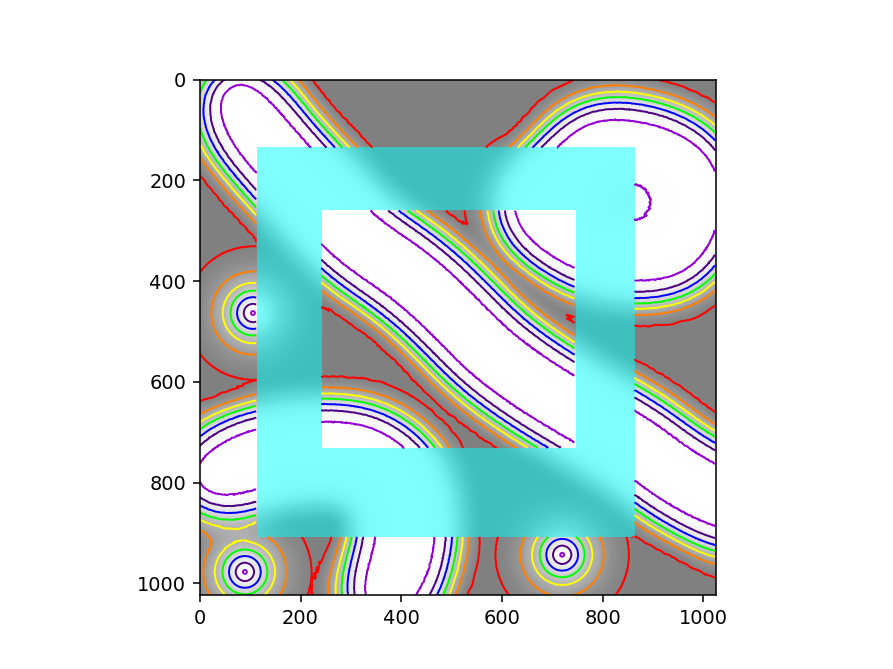

In [17]:
problem = create_test_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask)
plot_problem(problem, marching_square)

WOS detector (700K pixels)
==========================

In [13]:
problem = create_wos_problem()
print("With mask")
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = MarchingSquareCythonArrayOpt(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
print("Without mask")
marching_square = MarchingSquareSciKitImage(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = MarchingSquareCythonArrayOpt(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]

With mask
481 ms ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
34 ms ± 549 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
163 ms ± 7.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Without mask
129 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
33.8 ms ± 207 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
596 ms ± 43.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>


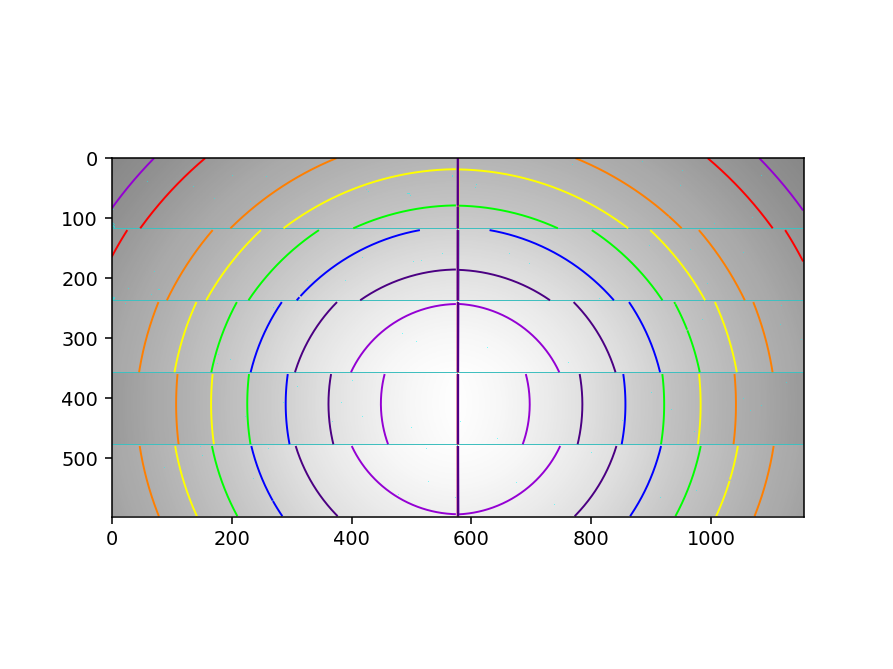

In [18]:
problem = create_wos_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask)
plot_problem(problem, marching_square)

Perkin Elmer (16M pixels)
=========================

In [15]:
problem = create_id22_17_problem()
print("With mask")
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = MarchingSquareCythonArrayOpt(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
print("Without mask")
marching_square = MarchingSquareSciKitImage(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = MarchingSquareCythonArrayOpt(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]

With mask
1.92 s ± 41.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.68 s ± 27.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
300 ms ± 8.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Without mask
1.62 s ± 38.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.26 s ± 20.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
258 ms ± 5.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
# On my machine
print("Speed up vs skimage: %s" % (1.61 / 0.215))

Speed up vs skimage: 7.488372093023257


<IPython.core.display.Javascript object>


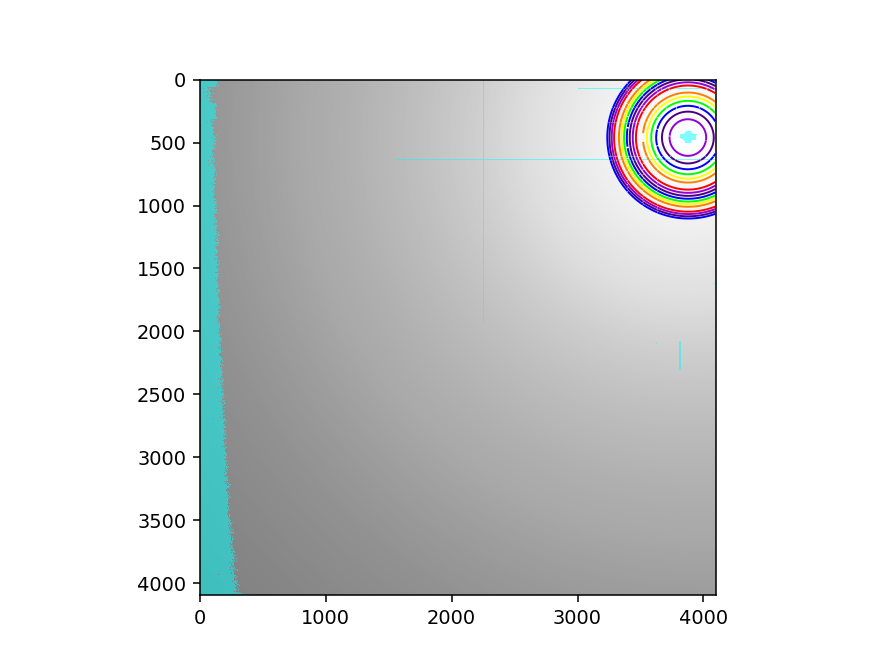

In [17]:
problem = create_id22_17_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask)
plot_problem(problem, marching_square)

<IPython.core.display.Javascript object>


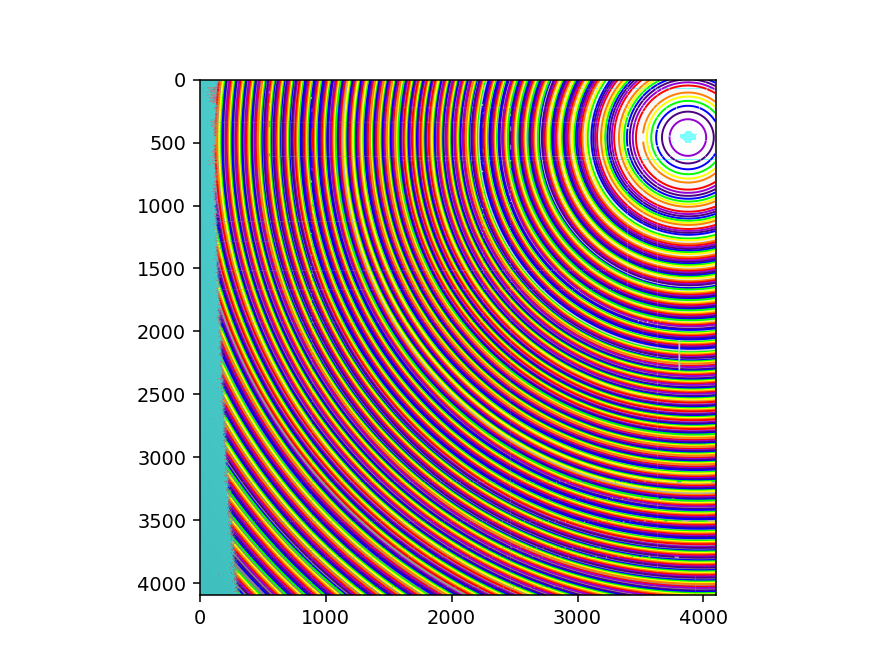

In [18]:
problem = create_id22_1441_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask)
plot_problem(problem, marching_square)

In [19]:
problem = create_id22_1441_problem()
marching_square = ThisMarchingSquare(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]

22.7 s ± 129 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Check result
============

In [38]:
def create_data(size):
    half = size // 2
    y, x = numpy.ogrid[-half:half, -half:half]
    coef = 1 / half
    y, x = y * coef, x * coef
    data = x*x + y*y
    data = x*x*(x*2) + y*y/2**numpy.sin(y*5)
    data = numpy.sin(data * 6, dtype=numpy.float32)
    return data

def create_test_problem(size=512):
    image = create_data(size)
    values = image.min() + numpy.array(range(10)) * (image.max() - image.min())
    values = values / len(values)
    return Problem(image=image, mask=None, values=values[1:-1])

<IPython.core.display.Javascript object>


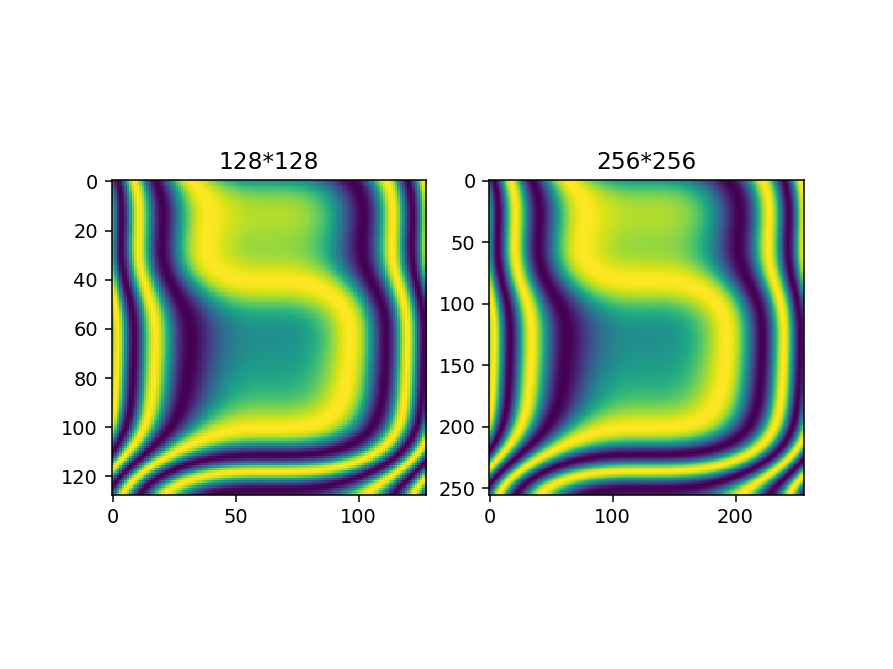

In [35]:
from matplotlib import pyplot
pyplot.figure()
pyplot.subplot(121)
pyplot.title("128*128")
pyplot.imshow(create_data(128))
pyplot.subplot(122)
pyplot.title("256*256")
pyplot.imshow(create_data(256))
pyplot.show()

<IPython.core.display.Javascript object>


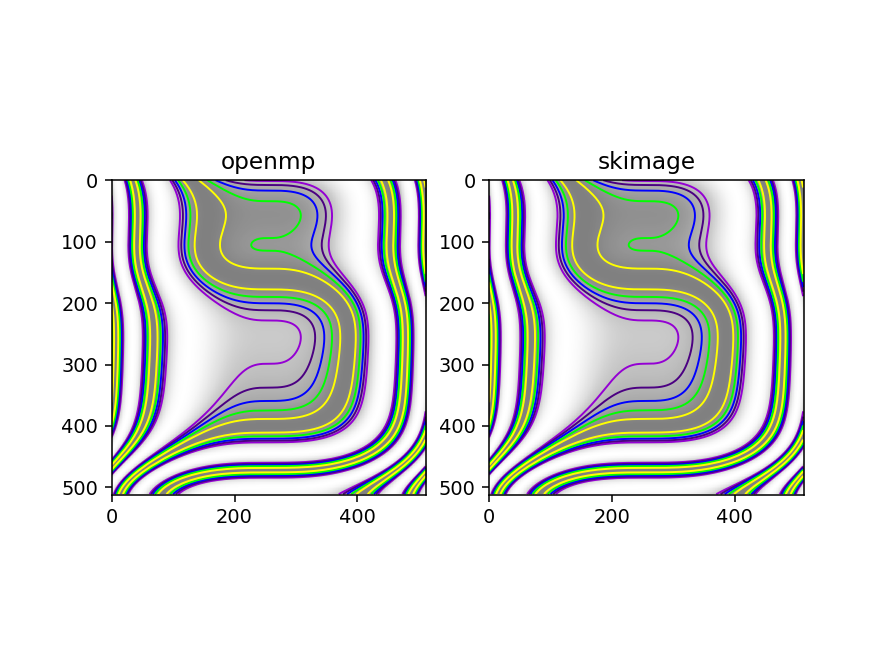

In [34]:
problem = create_test_problem()
pyplot.figure()
pyplot.subplot(121)
pyplot.title("openmp")
marching_square = ThisMarchingSquare(problem.image, problem.mask)
imshow_problem(problem, marching_square)
pyplot.subplot(122)
pyplot.title("skimage")
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
imshow_problem(problem, marching_square)
pyplot.show()

Influence of the kernel block size
==================================

In [39]:
import timeit

def get_t_dt(array):
    array = numpy.array(array)
    return array.mean(), array.max() - array.mean()


def time_problem(marching_square, problem):
    compute_time = timeit.repeat("[marching_square.iso_contour(a) for a in problem.values]",
                                 number=10, globals=locals())
    return get_t_dt(compute_time)


result = []

print("Scikit image")
problem = create_test_problem(1024)
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
t = time_problem(marching_square, problem)
result.append({'t': t, 'mode': 'skimage', 'size': 0, 'surface': 0})
for s in [32, 64, 100, 128, 256, 300, 512, 1024]:
    for m in ["tile", "row", "col"]:
        print("OpenMP %s %d" % (m, s))
        marching_square = ThisMarchingSquare(image=problem.image,
                                             mask=problem.mask,
                                             openmp_group_mode=m,
                                             openmp_group_size=s)
        t = time_problem(marching_square, problem)
        if m == "tile":
            surface = s * s
        elif m == "row":
            surface = s * problem.image.shape[0]
        elif m == "col":
            surface = s * problem.image.shape[1]

        result.append({'t': t, 'mode': m, 'size': s, 'surface': surface})

print(result)

Scikit image
OpenMP tile 32
OpenMP row 32
OpenMP col 32
OpenMP tile 64
OpenMP row 64
OpenMP col 64
OpenMP tile 100
OpenMP row 100
OpenMP col 100
OpenMP tile 128
OpenMP row 128
OpenMP col 128
OpenMP tile 256
OpenMP row 256
OpenMP col 256
OpenMP tile 300
OpenMP row 300
OpenMP col 300
OpenMP tile 512
OpenMP row 512
OpenMP col 512
OpenMP tile 1024
OpenMP row 1024
OpenMP col 1024
[{'t': (1.5632801720003044, 0.0704316290011775), 'mode': 'skimage', 'surface': 0, 'size': 0}, {'t': (1.7198927086665208, 0.09126540033321362), 'mode': 'tile', 'surface': 1024, 'size': 32}, {'t': (0.23298549366578905, 0.017605381333244935), 'mode': 'row', 'surface': 32768, 'size': 32}, {'t': (0.24882542666697796, 0.029299535333242005), 'mode': 'col', 'surface': 32768, 'size': 32}, {'t': (0.4428982670002976, 0.02902976299931953), 'mode': 'tile', 'surface': 4096, 'size': 64}, {'t': (0.23291099633388512, 0.012564214666781481), 'mode': 'row', 'surface': 65536, 'size': 64}, {'t': (0.342900006000491, 0.058674314999734634)

<IPython.core.display.Javascript object>


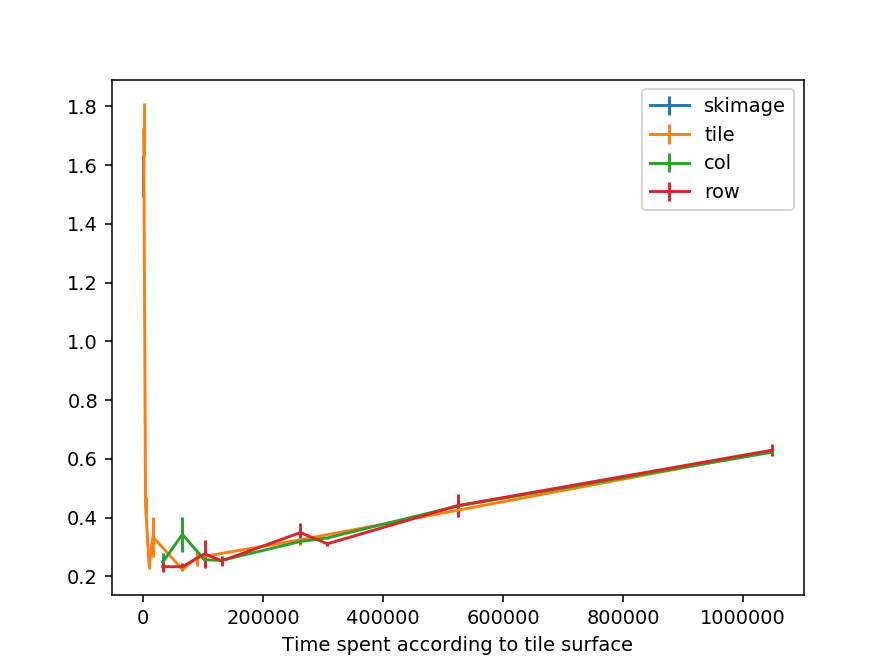

In [40]:
import numpy
from matplotlib import pyplot
import pylab

def errorbar_per(result, mode):
    result_image  = [v for v in result if v["mode"] == mode]
    x             = numpy.array([v["surface"] for v in result_image])
    compute_y     = numpy.array([v["t"][0] for v in result_image])
    compute_error = numpy.array([v["t"][1] for v in result_image])
    pylab.errorbar(x=x, y=compute_y, yerr=compute_error, linestyle="-", label=mode)

pyplot.figure()
errorbar_per(result, "skimage")
errorbar_per(result, "tile")
errorbar_per(result, "col")
errorbar_per(result, "row")
pylab.legend()
pylab.xlabel("Time spent according to tile surface")
pyplot.show()

Looks like a kernel surface around 256*256 512*512 is the best combination. Maybe only with this image size?

Anyway, it looks like there is no influence of the mode (tile/row/col).

Influence of the size of the polygons
=====================================

The algorithm uses a lot of reverse, which can create penalties with data containing a very long polygons.

We can try to generate different images containg the same amount of points, but with a different amout of polygones.

In [19]:
def create_spiral(size, nb=1, freq=100):
    half = size // 2
    y, x = numpy.ogrid[-half:half, -half:half]
    coef = 1 / half
    y, x = y * coef, x * coef + 0.0001
    distance = numpy.sqrt(x*x + y*y)
    angle = numpy.arctan(y/x)
    #data = x*x*(x*2) + y*y/2**numpy.sin(y*5)
    data = numpy.sin(angle * nb * 2 + distance * freq * half / 100, dtype=numpy.float32)
    data[distance < (size/20)*coef] = 0
    data[distance > half * coef] = 0
    return data

In [20]:
spiral_1 = create_spiral(1024, 1, 40)
spiral_2 = create_spiral(1024, 2, 40)
spiral_3 = create_spiral(1024, 4, 40)
spiral_4 = create_spiral(1024, 8, 40)

<IPython.core.display.Javascript object>


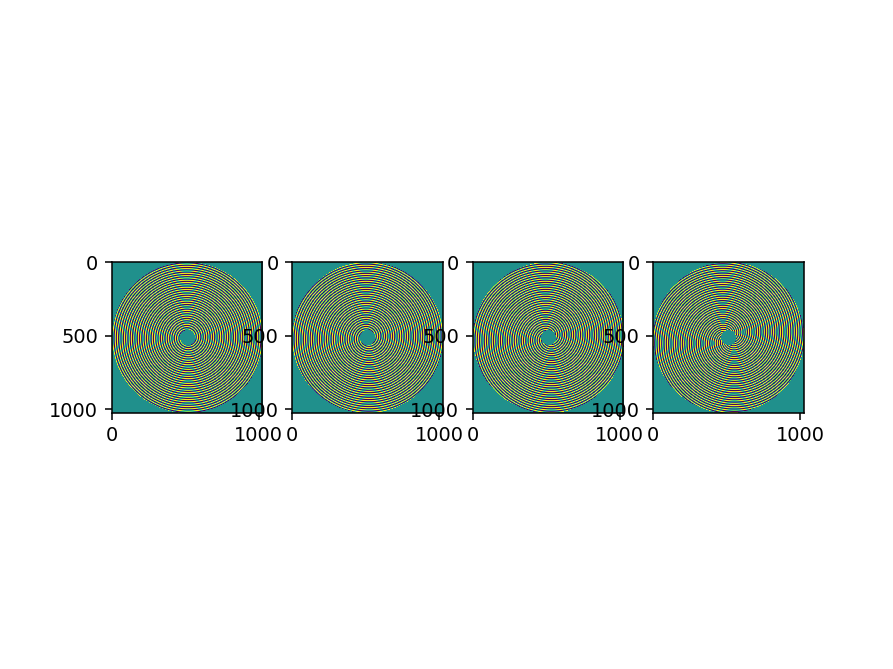

In [21]:
from matplotlib import pyplot
pyplot.figure()
pyplot.subplot(141)
pyplot.imshow(spiral_1)
pyplot.subplot(142)
pyplot.imshow(spiral_2)
pyplot.subplot(143)
pyplot.imshow(spiral_3)
pyplot.subplot(144)
pyplot.imshow(spiral_4)
pyplot.show()

In [22]:
def check_complexity(data):
    print("Check data")
    algo = ThisMarchingSquare(data)
    r = algo.iso_contour(data.mean())
    print("- nb polygons: %d", len(r))
    values = []
    nb_points = 0
    for p in r:
        nb_points += len(p)
        if len(p) < 20:
            continue
        values.append("%s" % len(p))
    print("- nb points: %d", nb_points)
    print("- nb points per poly: %s", ", ".join(values))

check_complexity(spiral_1)
check_complexity(spiral_2)
check_complexity(spiral_3)
check_complexity(spiral_4)

Check data
- nb polygons: %d 34
- nb points: %d 134088
- nb points per poly: %s 66929, 66873
Check data
- nb polygons: %d 45
- nb points: %d 134447
- nb points per poly: %s 33541, 33545, 33535, 33545
Check data
- nb polygons: %d 10
- nb points: %d 134547
- nb points per poly: %s 16767, 16768, 16821, 16837, 16829, 16839, 16839, 16837
Check data
- nb polygons: %d 46
- nb points: %d 136007
- nb points per poly: %s 8446, 8447, 8473, 8453, 8501, 8531, 8461, 8509, 8531, 8455, 8509, 8529, 8473, 8453, 8509, 8531


Data looks to be fine.

In [74]:
import timeit
import collections

Problem = collections.namedtuple("Problem", ["image", "mask", "values", "complexity"])

TimeCollect = collections.namedtuple('TimeCollect', ['image_size',
                                                     'nb_polygons',
                                                     'nb_pixels',
                                                     'nb_points',
                                                     'problem_complexity',
                                                     'algorithm_name',
                                                     'precache_t', 'precache_dt',
                                                     'postprocess_t', 'postprocess_dt',
                                                     'compute_t', 'compute_dt'])

def get_t_dt(array):
    array = numpy.array(array)
    return array.mean(), array.max() - array.mean()


def collect_computation(collected_result, algorithm_name, algorithm_factory, problem, number=10):
    values = problem.values

    algo = algorithm_factory(problem.image, problem.mask)
    result = []
    scope = dict(globals())
    scope.update(locals())

    compute_time = timeit.repeat("[result.append(algo.iso_contour(v)) for v in values]", number=number, globals=scope)
    compute_time = get_t_dt(compute_time)
    nb_pixels = problem.image.shape[0] * problem.image.shape[1]
    nb_points, nb_polygons = 0, 0
    for r in result:
        nb_polygons += len(r)
        for p in r:
            nb_points += len(p)
    t = TimeCollect(algorithm_name=algorithm_name,
                    image_size=problem.image.shape,
                    problem_complexity=problem.complexity,
                    nb_pixels=nb_pixels,
                    nb_polygons=nb_polygons,
                    nb_points=nb_points,
                    precache_t=0,
                    precache_dt=0,
                    postprocess_t=0,
                    postprocess_dt=0,
                    compute_t=compute_time[0],
                    compute_dt=compute_time[1])
    collected_result.append(t)

def get_algorithms(collected_result):
    result = set([r.algorithm_name for r in collected_result])
    result = sorted(result)
    return result

def get_result_per_algorithm(collected_result, algorithm_name):
    result = [r for r in collected_result if r.algorithm_name == algorithm_name]
    result = sorted(result, key=lambda r: r.image_size)
    return result

In [27]:
import pylab

styles = {
    "MarchingSquareCythonArray": {"linestyle": ":", "color": "green"},
    "MarchingSquareCythonArrayOpt": {"linestyle": "-", "color": "green"},
    "MarchingSquareSciKitImage": {"linestyle": "-", "color": "grey"},
    "MarchingSquareCythonMap": {"linestyle": "-", "color": "orange"},
    "MarchingSquareCythonInsert": {"linestyle": ":", "color": "red"},
    "MarchingSquareCythonInsertOpt": {"linestyle": "--", "color": "red"},
    "MarchingSquareCythonInsertOpenMp": {"linestyle": "-", "color": "red"},
    "MarchingSquareCythonInsertOpenMp_NoReverse": {"linestyle": "--", "color": "red"},
}

def plot_computation(collected_result, by_complexity=False):
    algorithms = get_algorithms(collected_result)

    if by_complexity:
        xlegend = "x-axis: problem complexity"
    else:
        xlegend = "x-axis: number of pixels"

    pyplot.figure()
    for i, algorithm in enumerate(algorithms):
        result = get_result_per_algorithm(collected_result, algorithm)
        if by_complexity:
            x = numpy.array([r.problem_complexity for r in result]) + 1
        else:
            x = numpy.array([r.nb_pixels for r in result]) + 1
        compute_y = numpy.array([r.compute_t for r in result])
        compute_error = numpy.array([r.compute_dt for r in result])
        style = styles.get(algorithm, {})
        pyplot.errorbar(x=x, y=compute_y, yerr=compute_error, label="%s" % (algorithm), **style)

    pylab.legend()
    # pyplot.gca().set_xscale("log", nonposx='clip')
    pylab.xlabel("Time spent (%s)" % xlegend)
    pyplot.legend
    pyplot.show()

def plot_computation_per_pixels(collected_result, by_complexity=False):
    algorithms = get_algorithms(collected_result)

    if by_complexity:
        xlegend = "x-axis: problem complexity"
    else:
        xlegend = "x-axis: number of pixels"

    pyplot.figure()
    for i, algorithm in enumerate(algorithms):
        result = get_result_per_algorithm(collected_result, algorithm)
        if by_complexity:
            x = numpy.array([r.problem_complexity for r in result]) + 1
        else:
            x = numpy.array([r.nb_pixels for r in result]) + 1
        nb_pixels = numpy.array([r.nb_pixels for r in result])
        compute_y = numpy.array([r.compute_t for r in result]) / nb_pixels * 1000000
        compute_error = numpy.array([r.compute_dt for r in result]) / nb_pixels * 1000000
        style = styles.get(algorithm, {})
        pyplot.errorbar(x=x, y=compute_y, yerr=compute_error, label="%s" % (algorithm), **style)

    pylab.legend()
    # pyplot.gca().set_xscale("log", nonposx='clip')
    pylab.xlabel("Time spent per pixel (micro-second) (%s)" % xlegend)
    pyplot.legend
    pyplot.show()

def plot_computation_per_points(collected_result, by_complexity=False):
    algorithms = get_algorithms(collected_result)

    if by_complexity:
        xlegend = "x-axis: problem complexity"
    else:
        xlegend = "x-axis: number of pixels"

    pyplot.figure()
    for i, algorithm in enumerate(algorithms):
        result = get_result_per_algorithm(collected_result, algorithm)
        if by_complexity:
            x = numpy.array([r.problem_complexity for r in result]) + 1
        else:
            x = numpy.array([r.nb_pixels for r in result]) + 1
        nb_points = numpy.array([r.nb_points for r in result])
        compute_y = numpy.array([r.compute_t for r in result]) / nb_points * 1000000
        compute_error = numpy.array([r.compute_dt for r in result]) / nb_points * 1000000
        style = styles.get(algorithm, {})
        pyplot.errorbar(x=x, y=compute_y, yerr=compute_error, label="%s" % (algorithm), **style)

    pylab.legend()
    # pyplot.gca().set_xscale("log", nonposx='clip')
    pylab.xlabel("Time spent per output points (micro-second)\n( (%s)" % xlegend)
    pyplot.legend
    pyplot.show()

In [25]:
problems = [
    Problem(spiral_1, None, [spiral_1.mean()], complexity=4),
    Problem(spiral_2, None, [spiral_2.mean()], complexity=3),
    Problem(spiral_3, None, [spiral_3.mean()], complexity=2),
    Problem(spiral_4, None, [spiral_4.mean()], complexity=1),
]

algorithms = [
    ("MarchingSquareCythonArrayOpt", lambda i, m: MarchingSquareCythonArrayOpt(i, m)),
    ("MarchingSquareSciKitImage", lambda i, m: MarchingSquareSciKitImage(i, m)),
    ("MarchingSquareCythonInsertOpenMp", lambda i, m: MarchingSquareCythonInsertOpenMp(i, m)),
    ("MarchingSquareCythonInsertOpenMp_NoReverse", lambda i, m: MarchingSquareCythonInsertOpenMp(i, m, use_reverse=False)),
]

collected_result = []

for problem in problems:
    print("Compute problem: image size = %s, iso contour count = %d" % (problem.image.shape, len(problem.values)))
    for name, factory in algorithms:
        print("- %s" % (name))
        collect_computation(collected_result, name, factory, problem)

print(collected_result)

Compute problem: image size = (1024, 1024), iso contour count = 1
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonInsertOpenMp
- MarchingSquareCythonInsertOpenMp_NoReverse
Compute problem: image size = (1024, 1024), iso contour count = 1
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonInsertOpenMp
- MarchingSquareCythonInsertOpenMp_NoReverse
Compute problem: image size = (1024, 1024), iso contour count = 1
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonInsertOpenMp
- MarchingSquareCythonInsertOpenMp_NoReverse
Compute problem: image size = (1024, 1024), iso contour count = 1
- MarchingSquareCythonArrayOpt
- MarchingSquareSciKitImage
- MarchingSquareCythonInsertOpenMp
- MarchingSquareCythonInsertOpenMp_NoReverse
[TimeCollect(image_size=(1024, 1024), nb_polygons=1020, nb_pixels=1048576, nb_points=4022640, problem_complexity=4, algorithm_name='MarchingSquareCythonArrayOpt', precache_t=0, pre

<IPython.core.display.Javascript object>


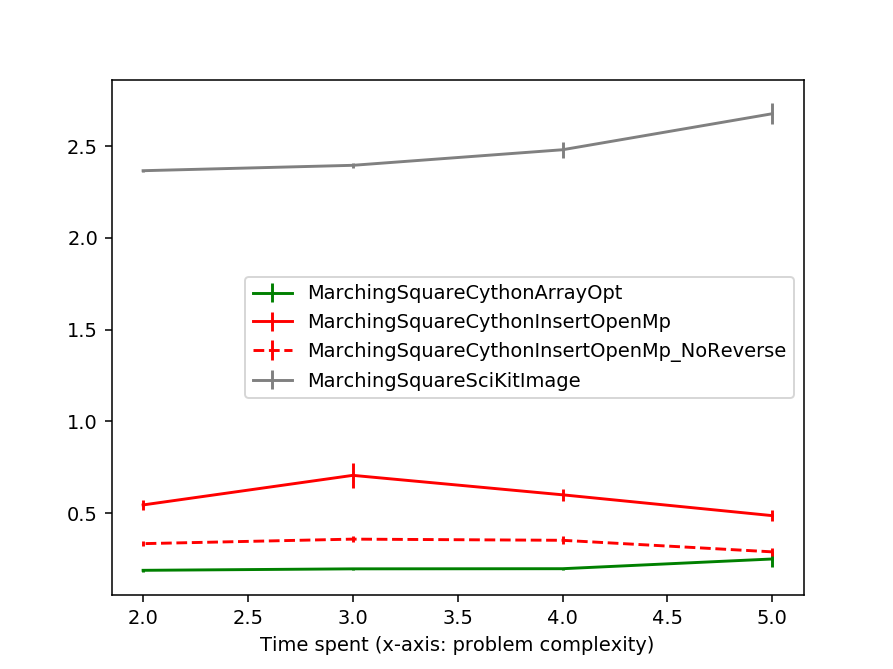

<IPython.core.display.Javascript object>


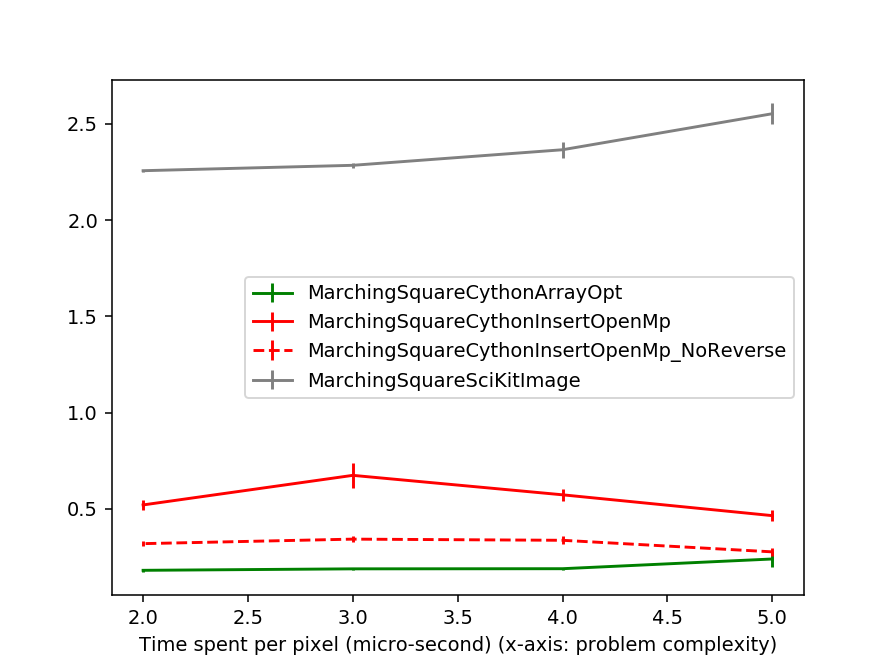

<IPython.core.display.Javascript object>


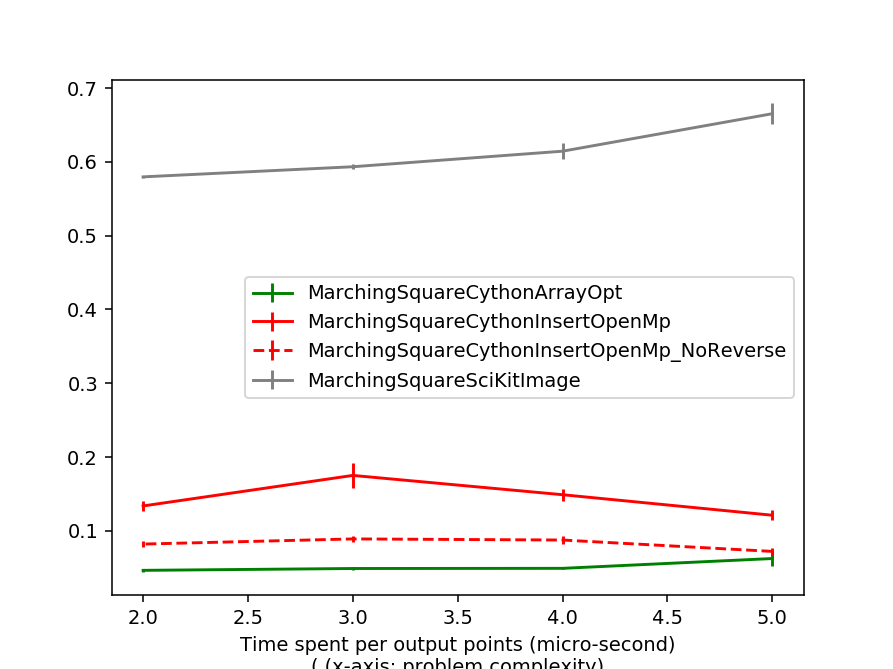

In [28]:
# Check computation time vs precache time
plot_computation(collected_result, by_complexity=True)
plot_computation_per_pixels(collected_result, by_complexity=True)
plot_computation_per_points(collected_result, by_complexity=True)

Impluence of the polygon cache
==============================

The algorithm currently do not clean up the cache for polygons stopped by a mask. This try to check the influence.

<IPython.core.display.Javascript object>


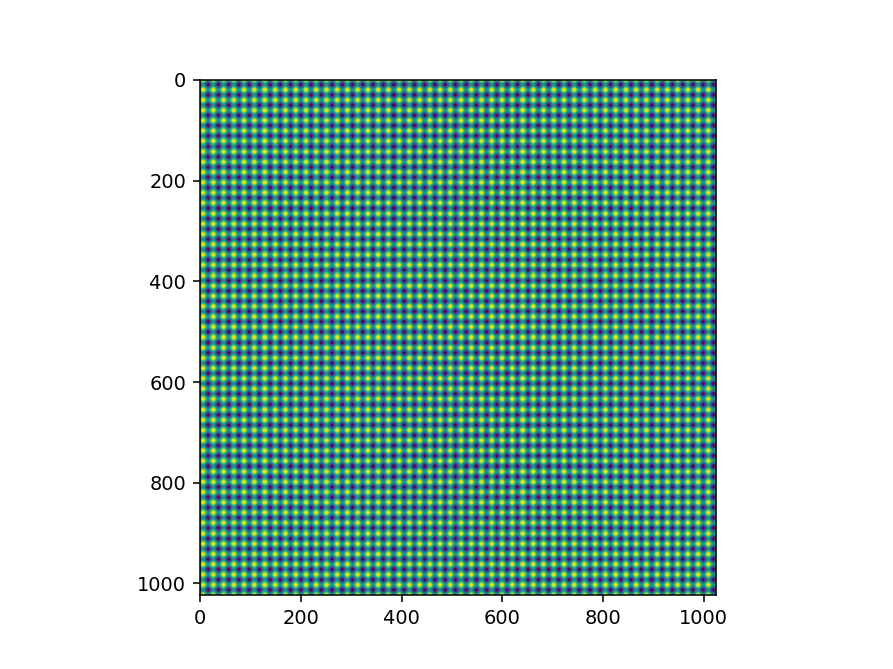

<IPython.core.display.Javascript object>


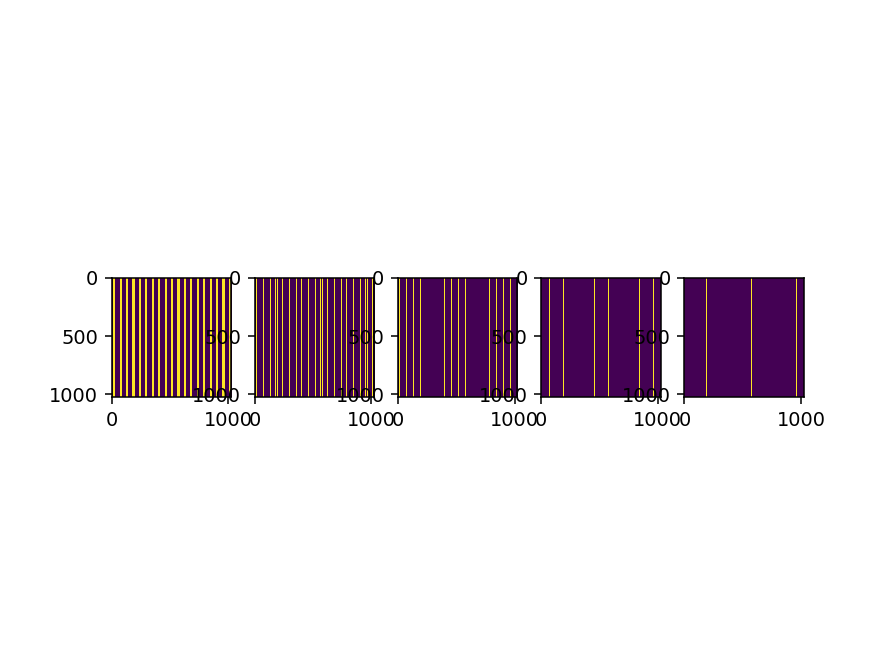

In [78]:
def create_circles(size, freq=100):
    half = size // 2
    y, x = numpy.ogrid[-half:half, -half:half]
    coef = 1 / half
    y, x = y * coef, x * coef
    data = numpy.sin(x * numpy.pi * freq) + numpy.cos(y * numpy.pi * freq)
    data = numpy.array(data, dtype=numpy.float32)
    return data

circles = create_circles(1024, 50)

mask_grid1 = numpy.zeros((1024, 1024), dtype=numpy.int8)
mask_grid1[:,::3] = 1
mask_grid2 = numpy.zeros((1024, 1024), dtype=numpy.int8)
mask_grid2[:,::6] = 1
mask_grid3 = numpy.zeros((1024, 1024), dtype=numpy.int8)
mask_grid3[:,::12] = 1
mask_grid4 = numpy.zeros((1024, 1024), dtype=numpy.int8)
mask_grid4[:,::24] = 1
mask_grid5 = numpy.zeros((1024, 1024), dtype=numpy.int8)
mask_grid5[:,::48] = 1

from matplotlib import pyplot

value = circles.min() + (circles.max() - circles.min()) * 0.60
problem = Problem(circles, mask_grid5, [value], complexity=5)


pyplot.figure()
pyplot.imshow(circles)
pyplot.show()

pyplot.figure()
pyplot.subplot(151)
pyplot.imshow(mask_grid1)
pyplot.subplot(152)
pyplot.imshow(mask_grid2)
pyplot.subplot(153)
pyplot.imshow(mask_grid3)
pyplot.subplot(154)
pyplot.imshow(mask_grid4)
pyplot.subplot(155)
pyplot.imshow(mask_grid5)
pyplot.show()

<IPython.core.display.Javascript object>


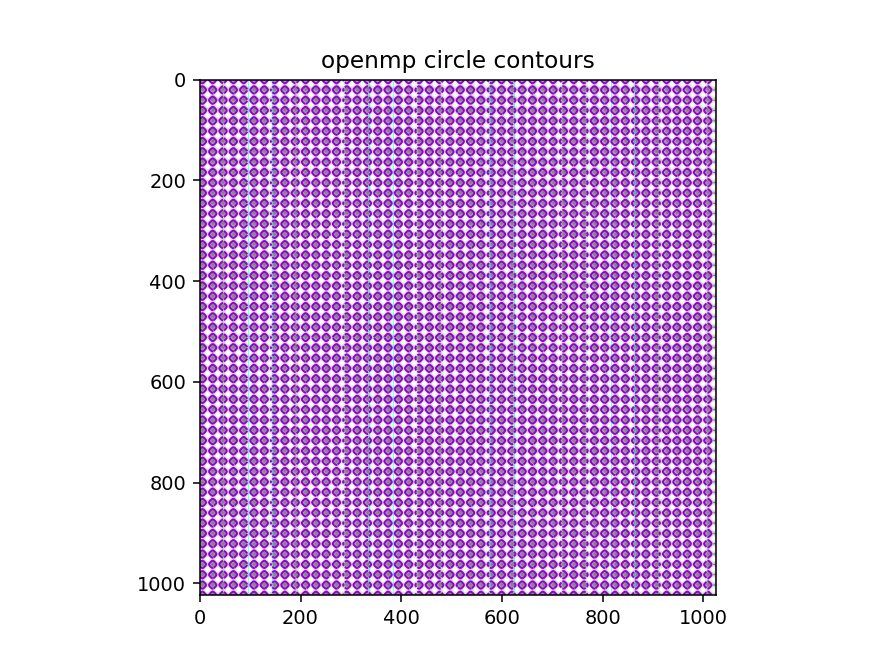

In [87]:
value = circles.min() + (circles.max() - circles.min()) * 0.60
problem = Problem(circles, mask_grid5, [value], complexity=5)

pyplot.figure()
pyplot.title("openmp circle contours")
marching_square = ThisMarchingSquare(problem.image, problem.mask)
imshow_problem(problem, marching_square)
pyplot.show()

In [88]:
problems = [
    Problem(circles, mask_grid1, [spiral_1.mean()], complexity=5),
    Problem(circles, mask_grid2, [spiral_2.mean()], complexity=4),
    Problem(circles, mask_grid3, [spiral_3.mean()], complexity=3),
    Problem(circles, mask_grid4, [spiral_4.mean()], complexity=2),
    Problem(circles, mask_grid5, [spiral_4.mean()], complexity=1),
]

algorithms = [
    ("MarchingSquareCythonArrayOpt", lambda i, m: MarchingSquareCythonArrayOpt(i, m)),
    ("MarchingSquareCythonInsertOpenMp", lambda i, m: MarchingSquareCythonInsertOpenMp(i, m)),
    ("MarchingSquareCythonInsertOpenMp_NoReverse", lambda i, m: MarchingSquareCythonInsertOpenMp(i, m, use_reverse=False)),
]

collected_result = []

for problem in problems:
    print("Compute problem: image size = %s, iso contour count = %d" % (problem.image.shape, len(problem.values)))
    for name, factory in algorithms:
        print("- %s" % (name))
        collect_computation(collected_result, name, factory, problem, number=10)

print(collected_result)

Compute problem: image size = (1024, 1024), iso contour count = 1
- MarchingSquareCythonArrayOpt
- MarchingSquareCythonInsertOpenMp
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703Bucket count changed from 1031 to 4703

Bucket count changed from 1031 to 4703Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703

Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket cou

Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703Bucket count changed from 1031 to 4703

Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703Bucket count changed from 1031 to 4703

Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from

Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703

Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from

Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703

Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from

Bucket count changed from 1031 to 4703Bucket count changed from 1031 to 4703

Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703

Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from 1031 to 4703
Bucket count changed from

Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179Bucket count changed from 1031 to 2179

Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179Bucket count changed from 1031 to 2179

Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179Bucket count changed from 1031 to 2179

Bucket count changed from

Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from

Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179

Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from

Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179Bucket count changed from 1031 to 2179
Bucket count changed from 

Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179Bucket count changed from 1031 to 2179

Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179

Bucket count changed from 1031 to 2179
Bucket count changed from

Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179Bucket count changed from 1031 to 2179

Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179Bucket count changed from 1031 to 2179

Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from

Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179Bucket count changed from 1031 to 2179Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179


Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from

Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179Bucket count changed from 1031 to 2179

Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179
Bucket count changed from 1031 to 2179Bucket count changed from 1031 to 2179

Bucket count changed from

- MarchingSquareCythonInsertOpenMp
- MarchingSquareCythonInsertOpenMp_NoReverse
Compute problem: image size = (1024, 1024), iso contour count = 1
- MarchingSquareCythonArrayOpt
- MarchingSquareCythonInsertOpenMp
- MarchingSquareCythonInsertOpenMp_NoReverse
[TimeCollect(image_size=(1024, 1024), nb_polygons=973530, nb_pixels=1048576, nb_points=2918520, problem_complexity=5, algorithm_name='MarchingSquareCythonArrayOpt', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=1.1405054373329524, compute_dt=0.07425343666424555), TimeCollect(image_size=(1024, 1024), nb_polygons=973530, nb_pixels=1048576, nb_points=2918520, problem_complexity=5, algorithm_name='MarchingSquareCythonInsertOpenMp', precache_t=0, precache_dt=0, postprocess_t=0, postprocess_dt=0, compute_t=1.4477961433331075, compute_dt=0.03162627566780429), TimeCollect(image_size=(1024, 1024), nb_polygons=973530, nb_pixels=1048576, nb_points=2918520, problem_complexity=5, algorithm_name='MarchingSquareCythonIns

<IPython.core.display.Javascript object>


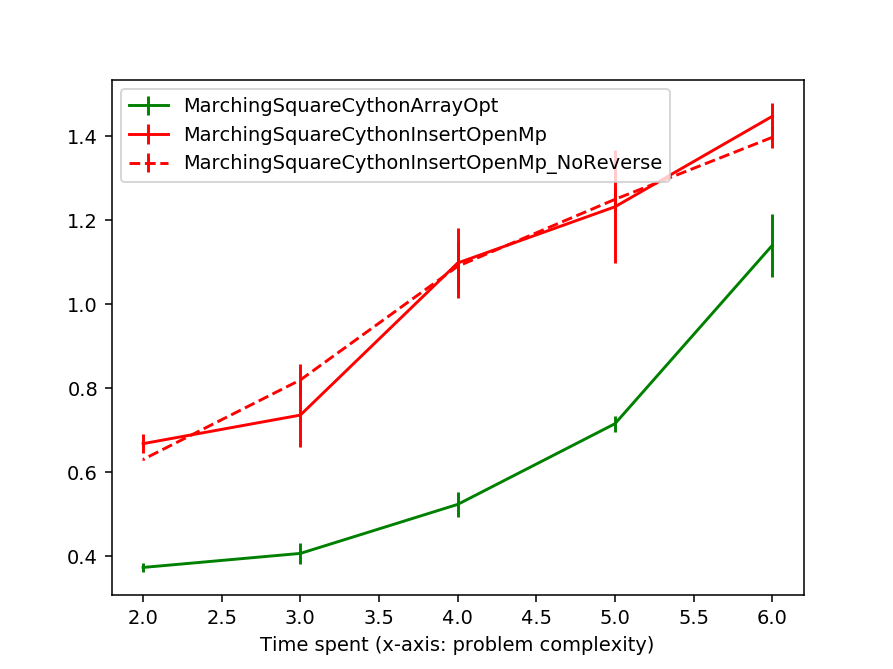

<IPython.core.display.Javascript object>


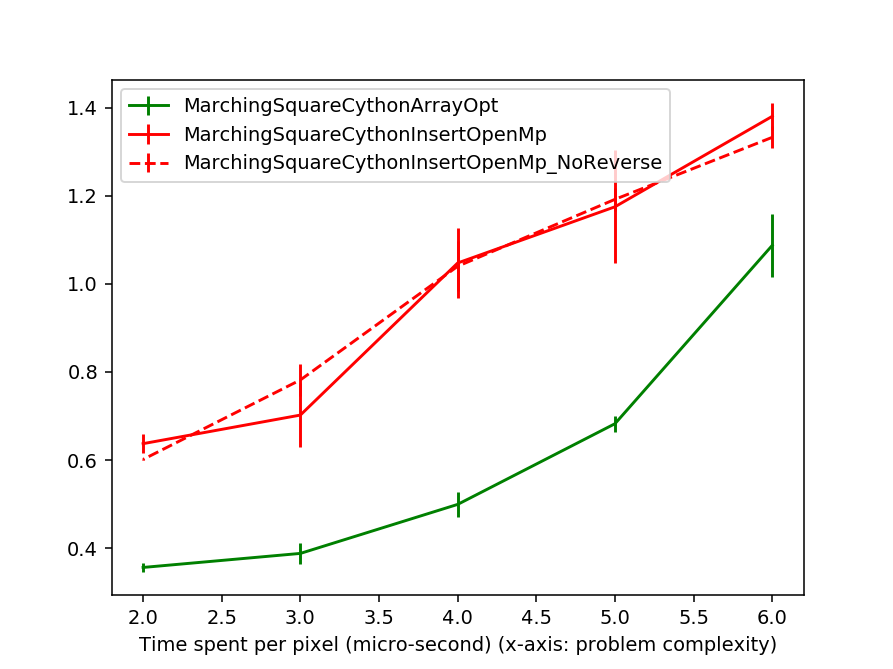

<IPython.core.display.Javascript object>


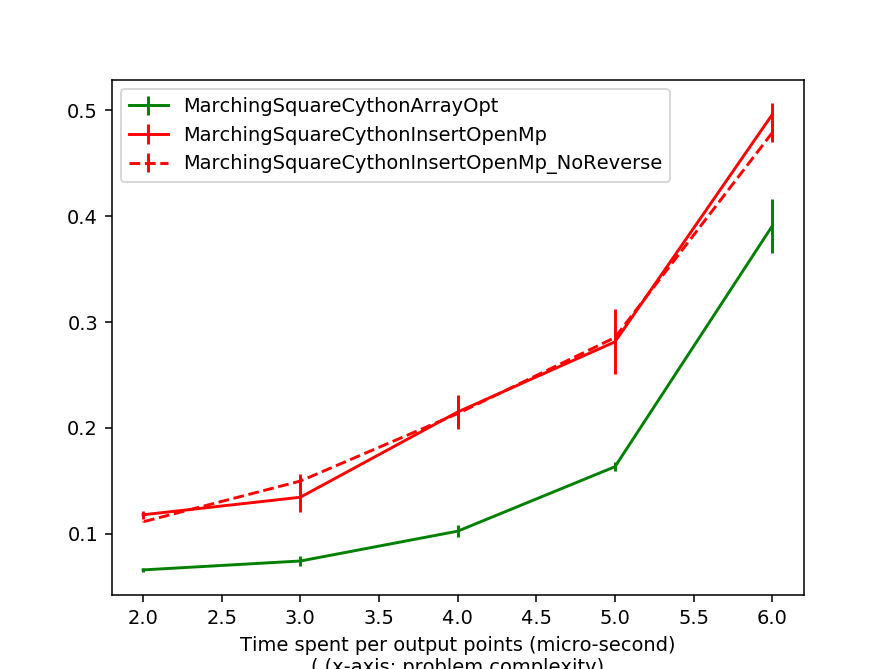

In [89]:
# Check computation time vs precache time
plot_computation(collected_result, by_complexity=True)
plot_computation_per_pixels(collected_result, by_complexity=True)
plot_computation_per_points(collected_result, by_complexity=True)